The overall idea is that we will implement linear and tree based models first and try to ensemble them. Further will implement recurrent NN and compare the two models.
Data normalisation required for linear or NN models will be done with the help of sklearn pipeline which will include both motel and data transofrmation steps. 

In [37]:
# TODO: try to train on log of target to smoothen extreme values
# TODO: experiment with removing trend in the label

In [1]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from tqdm.notebook import tqdm
from sklearn.svm import SVR

import torch
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.MLPModel import MLPModel
from src.ToyModel import ToyModel
from src.StackModel import StackModel
from src.utilities import run_cv, read_train
from src.FeatureGenerator import FeatureGenerator
from src.settings import SHIFTS, WINS, BATCH_FEATS_PATH

# CV data initiation

In [4]:
# initiating data generators
feat_generator = FeatureGenerator(verbose=True, save_files=True)

# initiating cv splitter
tscv = TimeSeriesSplit(test_size = 1, max_train_size=16)

# generating all of the data which we will iterate over during CV
features_df = feat_generator.generate_features()

# creating col lists for training
cols_di={
    'index': feat_generator.index_cols,
    'target': feat_generator.target_col,
    'feats': feat_generator.shifted_cols + feat_generator.roll_cols
}


base feats done
2 batches
shifts done
rolls done
batch 1/2 done
------------------------------
shifts done
rolls done
batch 2/2 done
------------------------------
concatenating


# Baseline

In [ ]:
# TODO: add lag based baseline

In [ ]:
# initiating toy model
toy_model = ToyModel()

# iterating over CV folds
toy_cv_res = run_cv(df=features_df, months_cv_split=tscv, model=toy_model, cols_di=cols_di, verbose=2)

Fold 0:
  Train months: [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28], size: 120,494
  Test months: [29],   size: 7,039
  NRMSE:  1.0
  RMSE :  5.1

Fold 1:
  Train months: [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29], size: 119,696
  Test months: [30],   size: 6,739
  NRMSE:  1.0
  RMSE :  4.4

Fold 2:
  Train months: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30], size: 118,557
  Test months: [31],   size: 5,669
  NRMSE:  1.0
  RMSE :  4.4

Fold 3:
  Train months: [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31], size: 116,851
  Test months: [32],   size: 5,439
  NRMSE:  1.0
  RMSE :  4.9

Fold 4:
  Train months: [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32], size: 114,617
  Test months: [33],   size: 5,668
  NRMSE:  1.0
  RMSE :  3.9


------------------------------
RMSE mean: 4.6
NRMSE mean: 1.0


# Linear model

In [ ]:
# initiating lin model
lin_model =  Pipeline([
    ("scaler", StandardScaler()),
    ("lin_model", LinearRegression()) #ElasticNet() Lasso(alpha=.005) , 
])

# iterating over CV folds
lin_cv_res = run_cv(df=features_df, months_cv_split=tscv, model=LinearRegression(), cols_di=cols_di, verbose=2)

Fold 0:
  Train months: [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28], size: 120,788
  Test months: [29],   size: 6,792
  NRMSE:  0.51
  RMSE :  2.7

Fold 1:
  Train months: [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29], size: 119,593
  Test months: [30],   size: 6,711
  NRMSE:  0.5
  RMSE :  2.2

Fold 2:
  Train months: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30], size: 118,420
  Test months: [31],   size: 5,796
  NRMSE:  0.41
  RMSE :  1.7

Fold 3:
  Train months: [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31], size: 116,815
  Test months: [32],   size: 5,293
  NRMSE:  0.69
  RMSE :  3.4

Fold 4:
  Train months: [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32], size: 114,487
  Test months: [33],   size: 5,523
  NRMSE:  0.68
  RMSE :  2.6


------------------------------
RMSE mean: 2.5
NRMSE mean: 0.56


# Tree based

In [ ]:
# let's optimise XGB parameters using half of the data for cross validation
df_for_optuna = features_df.sample(int(features_df.shape[0]*.5))

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, .6),
        'n_estimators': trial.suggest_int('n_estimators', 30, 1500),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 7.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 7.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0)
    }
    xgb = XGBRegressor(**params)
    tscv = TimeSeriesSplit(test_size = 1, max_train_size=16)
    tree_cv_res = run_cv(df=df_for_optuna, months_cv_split=tscv, model=xgb, cols_di=cols_di, verbose=0)
    
    return np.mean(tree_cv_res['rmse'])

study = optuna.create_study(direction='minimize', study_name='regression_2')
study.optimize(objective, n_trials=500)
print('Best parameters', study.best_params)

[I 2023-06-21 01:42:41,714] A new study created in memory with name: regression_2
[I 2023-06-21 01:47:11,722] Trial 0 finished with value: 6.9897120910578865 and parameters: {'max_depth': 4, 'learning_rate': 0.41698289836998387, 'n_estimators': 1259, 'gamma': 0.17016902289707253, 'reg_alpha': 5.446519384590239, 'reg_lambda': 1.1783654002455282, 'colsample_bytree': 0.8625074943452362, 'subsample': 0.40646225105372874}. Best is trial 0 with value: 6.9897120910578865.
[I 2023-06-21 01:54:41,979] Trial 1 finished with value: 3.7860422211664164 and parameters: {'max_depth': 11, 'learning_rate': 0.16535659271766526, 'n_estimators': 548, 'gamma': 0.14113466455754886, 'reg_alpha': 0.1294677861938847, 'reg_lambda': 4.159133641481722, 'colsample_bytree': 0.9895461814441767, 'subsample': 0.6373680373675246}. Best is trial 1 with value: 3.7860422211664164.
[I 2023-06-21 01:59:06,531] Trial 2 finished with value: 3.6563738586582373 and parameters: {'max_depth': 4, 'learning_rate': 0.416806120093770

Best parameters {'max_depth': 4, 'learning_rate': 0.056901755640135235, 'n_estimators': 214, 'gamma': 0.44716540258976356, 'reg_alpha': 0.30371993367372513, 'reg_lambda': 1.1152200659246774, 'colsample_bytree': 0.8339111689321749, 'subsample': 0.4358889399097483}


In [ ]:
# parameters found through 500 steps of optuna optimisation
params = {'max_depth': 4, 'learning_rate': 0.056901755640135235, 'n_estimators': 214, 'gamma': 0.44716540258976356, 
          'reg_alpha': 0.30371993367372513, 'reg_lambda': 1.1152200659246774, 'colsample_bytree': 0.8339111689321749, 
          'subsample': 0.4358889399097483}

tree_model = XGBRegressor(**params)

tree_cv_res = run_cv(df=features_df, months_cv_split=tscv, model=tree_model, cols_di=cols_di, verbose=2)

Fold 0:
  Train months: [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28], size: 120,596
  Test months: [29],   size: 6,879
  NRMSE:  0.46
  RMSE :  2.4

Fold 1:
  Train months: [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29], size: 119,541
  Test months: [30],   size: 6,774
  NRMSE:  0.46
  RMSE :  2.0

Fold 2:
  Train months: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30], size: 118,373
  Test months: [31],   size: 5,725
  NRMSE:  0.48
  RMSE :  2.1

Fold 3:
  Train months: [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31], size: 116,779
  Test months: [32],   size: 5,342
  NRMSE:  0.65
  RMSE :  3.2

Fold 4:
  Train months: [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32], size: 114,430
  Test months: [33],   size: 5,598
  NRMSE:  0.58
  RMSE :  2.2


------------------------------
RMSE mean: 2.4
NRMSE mean: 0.53


We see that in general both linear and XGB models do considerably better than baseline while optimised XGB achieves slightly better result in crossvalidation on this subset of data.

# Stacking

Let's now try to stack several simple models:
- Several MLPs
- Several tree based models trained with different parameters
- Several Ridge/ Lasso regressors 

In total about 6-8 models trained on subsets of columns/ rows. Prediction results from 1st level will be merged in a dataset and used as train for 2nd level models (KNN or linear). 2nd level models prediction will be either averaged if several models are passed or returned as final prediction if only 1 is passed. This way to train current level models we need to predict using prev. level models too. 

At each level of training data will be separated into train and test as done before, using rolling window with last month as test and all previous months as train. 

For the 1st level modelss, once training and prediction through rolling window is done (train data for 2nd lvl is produced), same models will be trained on all data available so that later these trained models could be used for final prediction.

2nd level models will be trained on all data produced for them right away since there is no 3rd level models, so rolling window CV is not required.

Let's implement this logic in code.

## Single models

Let's limit the test months to last 3 and try various single models on 3 fold cross validation to compare the scores to performance of a stacked model

In [ ]:
# TODO: add classifiers that predict categorised target
# TODO: try adding categorical feature transformation as a first pipeline step to each model
# TODO: experiemnt with one-hot -> augmentation encoding of categorical

lin_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lin_model", ElasticNet(alpha=.05, tol=1e-2))
])

params_1 = {'max_depth': 4, 'learning_rate': 0.056901755640135235, 'n_estimators': 214, 'gamma': 0.44716540258976356, 
          'reg_alpha': 0.30371993367372513, 'reg_lambda': 1.1152200659246774, 'colsample_bytree': 0.8339111689321749, 
          'subsample': 0.4358889399097483}
params_2 = {'max_depth': 3, 'learning_rate': 0.05934235376265128, 'n_estimators': 115, 'gamma': 0.9511344001105985, 
            'reg_alpha': 0.866979058629469, 'reg_lambda': 1.145739285194505, 'colsample_bytree': 0.6899975632569942, 
            'subsample': 0.43755627698663035}
params_3 = {'max_depth': 3, 'learning_rate': 0.0689247302849172, 'n_estimators': 159, 'gamma': 0.5364604960993917, 
            'reg_alpha': 1.2707904056672363, 'reg_lambda': 1.1198727987931234, 'colsample_bytree': 0.6885065220603901, 
            'subsample': 0.45772829230576445}

nn_pipe_sklearn = Pipeline([
    ("scaler", StandardScaler()),
    ('nn_model', MLPRegressor(hidden_layer_sizes=32, max_iter=500, activation='relu', batch_size=512, early_stopping=True))
])

nn_pipe_torch = Pipeline([
    ("scaler", StandardScaler()),
    ("nn_model", MLPModel(input_size=len(cols_di['feats'])))
])

svr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    # ("svr", SVR(kernel='linear'))
    ("svr", SVR(kernel='rbf'))
])

In [ ]:
single_models = [
    lin_pipe,
    nn_pipe_sklearn, 
    nn_pipe_torch,
    XGBRegressor(**params_1), XGBRegressor(**params_2), XGBRegressor(**params_3),
    RandomForestRegressor(n_jobs=-1), 
    CatBoostRegressor(allow_writing_files=False, silent=True),
]

model_names = [
    'linear',
    'nn_sklearn',
    'nn_torch',
    'xgb_1',
    'xgb_2',
    'xgb_3',
    'random_forest',
    'catboost'
]

In [ ]:
control_tscv = TimeSeriesSplit(test_size = 1, max_train_size=19, n_splits=3)

singular_results = []
for name, model in zip(model_names, single_models):
    print(f'####### {name} #######')
    singular_results.append(run_cv(df=features_df, months_cv_split=control_tscv, 
                                   model=model, cols_di=cols_di, verbose=2))
    print('='*60)

####### linear #######
Fold 0:
  Train months: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30], size: 142,266
  Test months: [31],   size: 5,778
  NRMSE:  0.38
  RMSE :  1.6

Fold 1:
  Train months: [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31], size: 139,710
  Test months: [32],   size: 5,457
  NRMSE:  0.69
  RMSE :  3.4

Fold 2:
  Train months: [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32], size: 137,266
  Test months: [33],   size: 5,716
  NRMSE:  0.5
  RMSE :  1.9


------------------------------
RMSE mean: 2.3
NRMSE mean: 0.53
####### nn_sklearn #######
Fold 0:
  Train months: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30], size: 142,266
  Test months: [31],   size: 5,778
  NRMSE:  0.42
  RMSE :  1.8

Fold 1:
  Train months: [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31], size: 139,710
  Test months: [32],   size: 5,457
  NRMSE:  0.73
  RMSE :  3.6

Fold 2:
  Train months: [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29

In [ ]:
scores_df = pd.DataFrame([(np.mean(el['nrmse']), np.mean(el['rmse'])) for el in singular_results], 
             columns=['nrmse', 'rmse'])
scores_df['model_names'] = model_names
scores_df.sort_values('nrmse')

,nrmse,rmse,model_names
7,0.471268,2.069945,catboost
3,0.484604,2.133791,xgb_1
4,0.500319,2.208529,xgb_2
5,0.508814,2.240230,xgb_3
0,0.525454,2.317589,linear
6,0.544340,2.372030,random_forest
2,0.553781,2.436808,nn_torch
1,0.599686,2.621395,nn_sklearn


## Stacked model

StackModel class have been implemented and moved to src.StackModel. Below we show an example how to use it as input to our ad hoc cross validation funciton. It's been confirmed that the score matches the singular model example given above if the list of models for level 1 consist of just one model used in the same example and level 2 models list is empty.

In [ ]:
control_tscv = TimeSeriesSplit(test_size = 1, max_train_size=19, n_splits=3)
level_1_models = [
    lin_pipe,
    nn_pipe_sklearn, 
    nn_pipe_torch,
    XGBRegressor(**params_1), XGBRegressor(**params_2), XGBRegressor(**params_3),
    RandomForestRegressor(n_jobs=-1), 
    CatBoostRegressor(allow_writing_files=False, silent=True),
]
level_2_model = [LinearRegression()] # svr_pipe

st_model = StackModel(lvl_1_models = level_1_models, lvl_2_models=level_2_model, month_col='date_block_num', 
                      lvl_1_feats=cols_di['feats'], target_col='target', train_ratio=.8)

tree_cv_res = run_cv(df=features_df, months_cv_split=control_tscv, model=st_model, cols_di=cols_di, verbose=2)

Fold 0:
  Train months: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30], size: 142,266
  Test months: [31],   size: 5,778
  NRMSE:  0.39
  RMSE :  1.7

Fold 1:
  Train months: [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31], size: 139,710
  Test months: [32],   size: 5,457
  NRMSE:  0.65
  RMSE :  3.2

Fold 2:
  Train months: [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32], size: 137,266
  Test months: [33],   size: 5,716
  NRMSE:  0.46
  RMSE :  1.8


------------------------------
RMSE mean: 2.2
NRMSE mean: 0.5


## Simple averaging

In [ ]:
control_tscv = TimeSeriesSplit(test_size = 1, max_train_size=19, n_splits=3)
level_1_models = [
    lin_pipe,
    nn_pipe_sklearn, 
    nn_pipe_torch,
    XGBRegressor(**params_1), XGBRegressor(**params_2), XGBRegressor(**params_3),
    RandomForestRegressor(n_jobs=-1), 
    CatBoostRegressor(allow_writing_files=False, silent=True),
]
level_2_model = []

st_model = StackModel(lvl_1_models = level_1_models, lvl_2_models=level_2_model, month_col='date_block_num', 
                      lvl_1_feats=cols_di['feats'], target_col='target', train_ratio=.65)

tree_cv_res = run_cv(df=features_df, months_cv_split=control_tscv, model=st_model, cols_di=cols_di, verbose=2)

Fold 0:
  Train months: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30], size: 142,266
  Test months: [31],   size: 5,778
  NRMSE:  0.34
  RMSE :  1.5

Fold 1:
  Train months: [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31], size: 139,710
  Test months: [32],   size: 5,457
  NRMSE:  0.65
  RMSE :  3.2

Fold 2:
  Train months: [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32], size: 137,266
  Test months: [33],   size: 5,716
  NRMSE:  0.45
  RMSE :  1.7


------------------------------
RMSE mean: 2.1
NRMSE mean: 0.48


We see that performance of stacked model and simple averging of predictions perform very similarly and on par but not better than best single models. But because this cross validation is not representative of the kaggle scoring logic it's worth trying to upload predictions yielded by all 3 of these approaches.

# Recurrent NN

Key RNN attributes for the problem at hand:
- <b>Token</b>: token is all features for current month, item and shop. Because all features we calculate for current month in fact don't look into the current month, but instead look into the past, no data leak occurs. It may be reasonable to limit the features we use to label lag only
- <b>Context</b>: context would be a sequence of tokens for the same item-shop combination but for past months. Context length is reasonable to keep to the length of the longest seasonality cycle we see in the data, i.e. -- 1 year, 12 months, 12 tokens, that is.

Let's first implement rnn using only target lag features

In [5]:
features_df = read_train()

In [198]:
rnn_feats = [col for col in features_df if 'target_lag' in col][::-1]
rnn_df = features_df[rnn_feats + ['target']]
rnn_df.head()

,target_lag_12,target_lag_8,target_lag_3,target_lag_2,target_lag_1,target
0,0.0,0.0,0.0,0.0,0.0,6.0
1,0.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,3.0


In [789]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_size:int, 
                 hidden_size: int=256, 
                 batch_size: int=32, 
                 num_epochs: int=15,
                 num_layers: int=1):
        super().__init__()
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.rnn = torch.nn.RNN(input_size=self.input_size, 
                                hidden_size=self.hidden_size,
                                num_layers=self.num_layers,
                                batch_first=True
                                )
        # expected input format: batch, num of lags, num of features -> batch, 5, 1
        self.linear = torch.nn.Linear(hidden_size, 1)
        
        self.losses = []
        self.optimiser = torch.optim.Adam(params=self.parameters(), lr=1e-2)
        
    def forward(self, 
                token: torch.Tensor):
        
        hidden_state = torch.zeros(self.num_layers, token.shape[0], self.hidden_size)
    
        out_token, _ = self.rnn(token, hidden_state)
        output = self.linear(out_token[:,-1,:])
        return output
    
    def _train_epoch(self, X: torch.Tensor, y: torch.Tensor):
        batch_X = X; batch_y = y
        # for ix in tqdm(range(0, len(X), self.batch_size)):
        #     batch_X = X[ix : ix + self.batch_size]; batch_y = y[ix : ix + self.batch_size]
        #     if batch_X.shape[0] == self.batch_size:
        rnn_output = self.forward(token=batch_X)
    
        loss = torch.nn.functional.mse_loss(input=rnn_output.flatten(), target=batch_y.flatten())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
                
        self.losses.append(loss.detach().numpy())


    def fit(self, X, y):
        for _ in tqdm(range(self.num_epochs)):
            self._train_epoch(X, y)

    def predict(self, X):
        if not type(X) == torch.Tensor:
            X = torch.Tensor(X).float()
        if len(X.shape)<3:
            X = X.unsqueeze(-1)
        print(X.shape)
        return self.forward(token=X)

In [790]:
def construct_fake_df(df_len: int=20000, 
                      lookback_window: int=15,
                      lags_list: list=[12, 8, 3, 2, 1]):
    x = np.array(range(1, df_len))
    y = np.sin(x/10) + x/100

    X = []
    for ix, val in enumerate(y[:-(lookback_window-1)]):
        X.append(y[ix: ix+(lookback_window+1)][::-1])
    
    feats_cols = [f'lag_{col+1}' for col in range(lookback_window)]
    out_df = pd.DataFrame(X, columns=['target'] + feats_cols).dropna()
    
    if len(lags_list) > 0:
        filtered_cols  = [col for col in feats_cols if col in [f'lag_{num}' for num in lags_list]][::-1]
    else: 
        filtered_cols = feats_cols
    # cols = [['target'] + feats_cols]
    return out_df[['target'] + filtered_cols], filtered_cols
fake_df, rnn_feats = construct_fake_df(df_len=10000, lookback_window=7, lags_list=list(range(1,7))+[12, 23, 32])
rnn_feats

['lag_6', 'lag_5', 'lag_4', 'lag_3', 'lag_2', 'lag_1']

In [796]:
rnn = RNNModel(input_size=1, 
               hidden_size=256, 
               batch_size=10000, 
               num_epochs=80,
               num_layers=1)

In [797]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
tmp_X = scaler_X.fit_transform(fake_df[rnn_feats].values)
tmp_y = scaler_y.fit_transform(fake_df['target'].values.reshape(-1,1))

tmp_X = torch.Tensor(tmp_X).float().unsqueeze(dim=-1)
tmp_y = torch.Tensor(tmp_y).float()#.unsqueeze(dim=-1)

rnn.fit(X=tmp_X, y=tmp_y)

  0%|          | 0/80 [00:00<?, ?it/s]

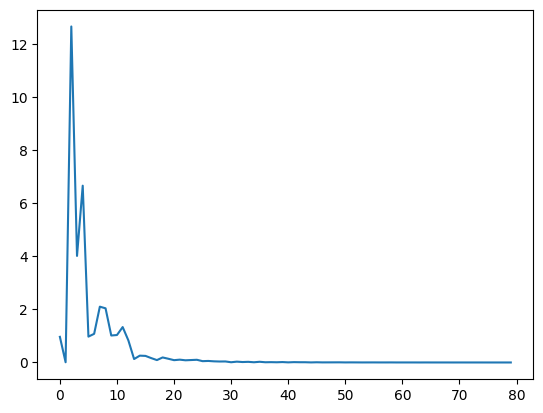

In [798]:
factor=1
smoothed_losses = np.array(rnn.losses)[:factor*(len(rnn.losses)//factor)].reshape(-1,factor).mean(axis=1)
plt.plot(smoothed_losses)
# plt.ylim(0, .1)

torch.Size([5000, 6, 1])


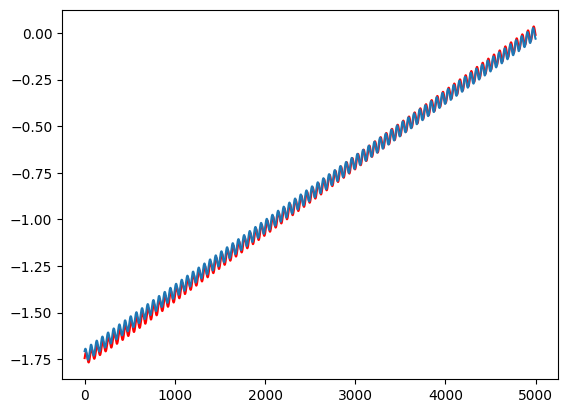

In [800]:
lim = 5000
pred = rnn.predict(X=tmp_X[:lim]).detach().numpy()

plt.plot(pred, color='r')
# plt.plot(fake_df['target'].values[:lim], color='g')
plt.plot(tmp_y[:lim])

In [721]:
import torch
import torch.nn as nn
import numpy as np

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


# Set the hyperparameters
input_size = 1
hidden_size = 128
output_size = 1
num_layers = 1
learning_rate = 0.01
num_epochs = 500

seq_length = 7

# Create the model
model = RNN(input_size, hidden_size, output_size, num_layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Generate the training data
x = np.arange(1, 1000)
# y = np.sin(x/10)  + x/10
y = (np.sin(x/10)/x)*100 +  x/300

# Create the input and target sequences
x_train = []
y_train = []

for i in range(seq_length, len(y)):
    x_train.append(y[i-seq_length:i])
    y_train.append(y[i])

x_train = torch.tensor(x_train).float().view(-1, seq_length, 1)
y_train = torch.tensor(y_train).float().view(-1, 1)

# Train the model
for epoch in range(num_epochs):
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch: 100/500, Loss: 0.0071
Epoch: 200/500, Loss: 0.0004
Epoch: 300/500, Loss: 0.0001
Epoch: 400/500, Loss: 0.0027
Epoch: 500/500, Loss: 0.0001


In [722]:
pred = model.forward(x_train)

In [723]:
x = np.arange(1, 1000)
y = (np.sin(x/10)/x)*100 +  x/300

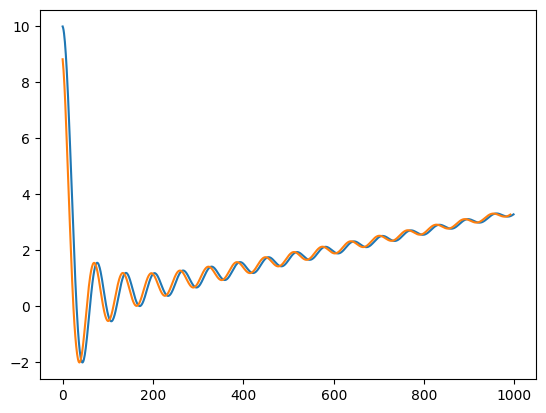

In [725]:
plt.plot(y)
plt.plot(pred.flatten().detach().numpy())